# 全连接网络分类fully connected neural networks

In [52]:
import pandas as pd
import jieba
import re
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
%matplotlib inline

In [8]:
filename = r'D:\dataset\movie_comments.csv'
mc = pd.read_csv(filename,encoding = 'utf-8')
mc.head(7)

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1
5,6,https://movie.douban.com/subject/26363254/,战狼2,“犯我中华者，虽远必诛”，吴京比这句话还要意淫一百倍。,1
6,7,https://movie.douban.com/subject/26363254/,战狼2,脑子是个好东西，希望编剧们都能有。,2


In [4]:
mc.shape

(261497, 5)

In [5]:
mc = mc[pd.notnull(mc['comment'])]
mc.shape

(261495, 5)

In [6]:
mc.drop_duplicates(['comment'],inplace = True)
mc.shape

(213970, 5)

In [14]:
def comment_word_token(comment):
    if not isinstance(comment,str):
        print(comment)
        return
    pattern = re.compile('[\u4E00-\u9FA5]')
    only_chinese = pattern.findall(comment)
    chinese_comment = ''.join(only_chinese)
    chinese_tokens = jieba.cut(chinese_comment)
    word_tokens = ' '.join(chinese_tokens)
    if word_tokens == '':
        return None
    return word_tokens

In [19]:
mc['word_tokens'] = mc['comment'].apply(comment_word_token)

In [20]:
mc = mc[pd.notnull(mc['word_tokens'])]
mc.shape

(253336, 6)

In [25]:
mc.index = range(mc.shape[0])

In [29]:
def plot_star_count(count_star):
    plt.figure(figsize=(12,4))
    sns.barplot(count_star.index, count_star.values, alpha=0.8)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Star', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

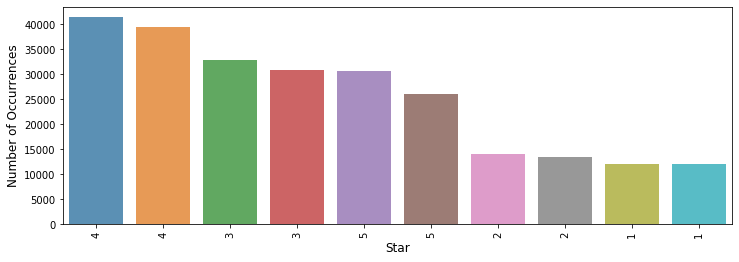

In [31]:
plot_star_count(mc['star'].value_counts())

In [34]:
num_str_list = ['0', '1', '2', '3', '4', '5']
for i in range(len(num_str_list)):
    mc.loc[mc['star'] == num_str_list[i], 'star'] = i

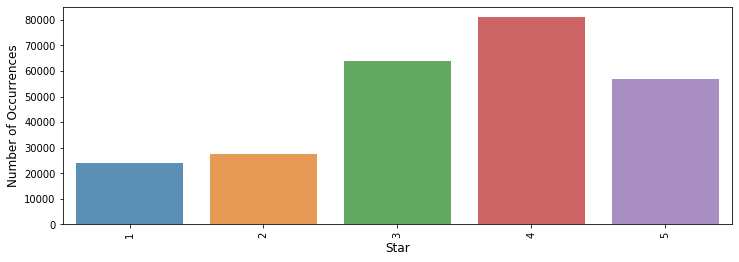

In [36]:
plot_star_count(mc['star'].value_counts())

In [37]:
star_counts = mc['star'].value_counts()

In [38]:
size_per_class = star_counts.min()

In [39]:
star_class_list = mc['star'].unique().tolist()
star_class_list.sort()

In [40]:
print(star_class_list)

[1, 2, 3, 4, 5]


In [41]:
def make_banlance_samples(mc, star_class, size_per_class):
    tmp_ser = mc['word_tokens'][mc['star'] == star_class]
    if tmp_ser.shape[0] > size_per_class:
        tmp_ser = tmp_ser.sample(n=size_per_class, random_state=42)
    tmp_ser.index = range(tmp_ser.shape[0])
    #tmp_ser.name = 'star_{}'.format(star_class)
    return tmp_ser

In [44]:
def merge_mc(mc, star_class_list, size_per_class):
    new_mc = pd.DataFrame()
    for star_class in star_class_list:
        star_ser = make_banlance_samples(mc, star_class, size_per_class)
        #star = 'star_{}'.format(star_class)
        new_mc = pd.concat([new_mc, pd.DataFrame(star_ser)], axis=1, ignore_index=True)
        #new_df = new_df.append(make_banlance_samples(df, star_class, size_per_class))
    
    return new_mc

In [48]:
new_mc = merge_mc(mc, star_class_list, size_per_class)
new_mc.columns=['star_1', 'star_2', 'star_3', 'star_4','star_5']

In [49]:
new_mc.head()

,star_1,star_2,star_3,star_4,star_5
0,吴京 意淫 到 了 脑残 的 地步 看 了 恶心 想 吐,牵强,好 吧 新海 诚 你 到底 矫情 到 什么 程度 才 算是 个 完 星星 之声 看来 是 难...,父 跑跑 妈 抱抱 中产 烦恼 知多少 雪山 仿若 幻境 拍得 很 好 在 一片 白 里面 ...,世界 上 最酷 的 猪
1,中二得 很,不 喜欢 这种 手持 风格,获 戛纳 影展 金棕榈奖 费 比西 奖 纽约 影评人 协会 最佳 外语片 费里尼 背叛 三部曲,三个 儿子 都 不是 亲生 的,一部 男人 戏中 刘嘉玲 真 真让人 过目难忘
2,犯 我 中华 者 虽远必 诛 吴京 比 这句 话 还要 意淫 一百倍,想和彪 猫蕊 唱,现在 来看 就 像 一部 小品,结尾 真是 厉害 啊,很 男人 但 我 一直 不 明白 关于 那个 变态 和 小女孩
3,吴京 的 冷峰 在 这部 里 即 像 成龙 又 像杰 森斯坦 森但 体制 外 的 同 类型 ...,看 的 第一部 同性 电影 真是 不想 说 什么 了 谜 之 编剧 谜 之 导演 不过 取景...,杀人 王,男爵 男爵 男爵,力量感 爆棚 了 啊 话 说 双生 加 起来 不过 抵上 个 王羽 的确如此
4,犯 我 中华 者 虽远必 诛 是 有 多 无脑 才 信 这句 话,好 无聊 被 骗 了,那 时候 的 董洁 真美 啊 真美,警匪 僵尸 片,理解能力 有限


In [50]:
new_mc.to_csv('douban.csv',index=False)